In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Exploratory Data Analysis

[Change the link]

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/getting-started/intro_gemini_1_5_flash.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fgetting-started%2Fintro_gemini_1_5_flash.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/getting-started/intro_gemini_1_5_flash.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/getting-started/intro_gemini_1_5_flash.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


## Overview

[add overview]

[add what you learned in previous notebook and link] - skip if its first


[Context of this notebook compared to overall idea]

## Getting Started

### Install Dependencies


***add all the dependencies

In [ ]:
! pip3 install --upgrade --user --quiet google-cloud-aiplatform
! pip3 install --user --quiet pydub pandas wordcloud matplotlib
! pip3 install --user --quiet nltk moviepy PyPDF2 scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 17.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.6 MB/s eta 0:00:00


### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

In [ ]:
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.


In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
# Define project information
PROJECT_ID = ""  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "mlops-for-genai" # @param {type:"string"}
# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

# Initialize cloud storage
from google.cloud import storage

storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.bucket(BUCKET_NAME)

### Import libraries


In [ ]:
import io
import json
import os
import tempfile
from io import BytesIO
from collections import Counter
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wordcloud
import PyPDF2
import nltk
from google.cloud import storage
from IPython.core.interactiveshell import InteractiveShell
from moviepy.editor import VideoFileClip
from nltk import ngrams
from pydub import AudioSegment
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Part,
)
from wordcloud import STOPWORDS, WordCloud

import IPython.display

InteractiveShell.ast_node_interactivity = "all"  # Optional configuration

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Load the models

To learn more about all [Gemini API models on Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models#gemini-models).


In [ ]:
MODEL_ID_PRO = "gemini-1.5-pro-001"  # @param {type:"string"}
MODEL_ID_FLASH = "gemini-1.5-flash-001" # @param {type:"string"}

model_pro = GenerativeModel(MODEL_ID_PRO)
model_flash = GenerativeModel(MODEL_ID_FLASH)

### Add data path

In [ ]:
prototype_data = "multimodal-finanace-qa/data/unstructured/prototype/"  # @param {type:"string"}
production_data = "multimodal-finanace-qa/data/unstructured/production/"  # @param {type:"string"}

In [ ]:
#@title Gemini API Function

def get_gemini_response(model, generation_config=None,
                    safety_settings=None,
                    uri_path=None,mime_type=None, prompt=None):
  if not generation_config:
    generation_config = {
      "max_output_tokens": 8192,
      "temperature": 1,
      "top_p": 0.95,
    }

  if not safety_settings:
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    }

  file = Part.from_uri(
    mime_type=mime_type,
    uri=uri_path
    )
  responses = model.generate_content([file, prompt],
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True,
  )
  final_response = []
  for response in responses:
    try:
      final_response.append(response.text)
    except ValueError:
      # print("Something is blocked...")
      final_response.append("blocked")

  return "".join(final_response)

## Exploring Prototype Data

### Overall files

In [ ]:
for blob in bucket.list_blobs():
  if blob.name.startswith(prototype_data):
    print(blob.name)

multimodal-finanace-qa/data/unstructured/prototype/alphabet_2023_q4_earnings_call.mp3
multimodal-finanace-qa/data/unstructured/prototype/goog-10-q-q2-2023-4-1-15.pdf
multimodal-finanace-qa/data/unstructured/prototype/google_cloud_tpu_blog_training.pdf
multimodal-finanace-qa/data/unstructured/prototype/google_gemini_intro_video.mp4
multimodal-finanace-qa/data/unstructured/prototype/google_responsible_ai.mp4
multimodal-finanace-qa/data/unstructured/prototype/google_search_next_phase_with_ai.mp4


### Audio files

In [ ]:
#@title Audio Feature Extraction Helper Functions

audio_sentiment_analysis_prompt = f"""Analyze the given audio.
Extract the following:
1) Provide the overall sentiment as positive, negative, or neutral.
2) Extract the top 5 phrases that most strongly contribute to the overall sentiment.
3) Extract the top 10 most relevant keywords.
4) Identify the different speakers present.
5) Summarize the audio in 3-5 concise sentences. Focus on the main points, key findings, and overall takeaways.

Expected Output Format:
      {{
  "overall_sentiment": "positive/negative/neutral",
  "contributing_phrases": [
    "phrase 1",
    "phrase 2",
    "phrase 3",
    "phrase 4",
    "phrase 5"
  ],
  "keywords": [
    "keyword 1",
    "keyword 2",
    ...,
    "keyword 10"
  ],
  "speakers": [
    "speaker 1",
    "speaker 2",
    ...,
    "speaker 5"
  ],
  "summary": "summary of the audio"
}}
"""

def get_blob_uri(bucket_name: str, blob_name: str) -> str:
    """Gets the full URI of the blob in Google Cloud Storage.

    Args:
        bucket_name: The name of the GCS bucket.
        blob_name: The name of the blob within the bucket.

    Returns:
        The full GCS URI (gs://...) of the blob.
    """
    return f"gs://{bucket_name}/{blob_name}"

def get_gemini_response_json(file_path="", mime_type="", analysis_prompt=""):
  # control generation for JSON using Gemini Flash
  cg_model = GenerativeModel(
      model_name="gemini-1.5-flash",
      generation_config={"response_mime_type": "application/json"},
  )

  content = [Part.from_uri(file_path,mime_type=mime_type), analysis_prompt]

  response = cg_model.generate_content(content)

  json_response = json.loads(response.text)
  return (json_response)


def analyze_audio(audio_bytes: io.BytesIO) -> Dict:
    """Analyzes audio data using PyDub and extracts metadata.

    Args:
        audio_bytes: An in-memory bytes buffer containing the audio data.

    Returns:
        A dictionary containing audio metadata (duration, size, sampling rate, channels).
    """
    try:
      try:
        audio = AudioSegment.from_file(audio_bytes, format="mp3")
      except:
        audio = AudioSegment.from_file(audio_bytes, format="mp4")
    except AudioSegment.CouldntDecodeError as e:
        raise ValueError("Could not decode audio file (ensure it's MP3 format).") from e

    return {
        "duration_in_min": audio.duration_seconds / 60,
        "size_in_mb": len(audio_bytes.getvalue()) / (1024 * 1024),
        "sampling_rate_in_hz": audio.frame_rate,
        "channels": audio.channels,

    }


def analyze_audio_in_gcs(
    bucket: storage.Bucket,
    gcs_data_path: str,
    audio_analysis_prompt: str,
    do_gemini_analysis: bool = True,  # New optional parameter
) -> pd.DataFrame:
    """Analyzes MP3 audio files from a Google Cloud Storage bucket.

    Args:
        bucket: A GCS Bucket object.
        gcs_data_path: The prefix to filter blobs in the bucket.
        audio_analysis_prompt: The prompt to use for Gemini audio analysis.
        do_gemini_analysis: Whether to perform Gemini analysis (default: True).

    Returns:
        A Pandas DataFrame containing analysis results for each matching audio file.
    """

    audio_metadata = []

    for blob in bucket.list_blobs(prefix=gcs_data_path):  # Using prefix for efficiency
        if blob.name.endswith(".mp3"):
            audio_bytes = io.BytesIO()
            blob.download_to_file(audio_bytes)
            audio_bytes.seek(0)

            metadata = analyze_audio(audio_bytes)
            metadata["blob_name"] = blob.name.split("/")[-1]
            metadata["blob_path"] = get_blob_uri(bucket.name, blob.name)
            metadata["data_type"] = blob.name.split("/")[-2]

            if do_gemini_analysis:
                audio_analysis_data = get_gemini_response_json(
                    file_path=get_blob_uri(bucket.name, blob.name),
                    mime_type="audio/mp3",
                    analysis_prompt=audio_analysis_prompt,
                )

                metadata.update(
                    {
                        "overall_sentiment": audio_analysis_data["overall_sentiment"],
                        "contributing_phrases": audio_analysis_data["contributing_phrases"],
                        "keywords": audio_analysis_data["keywords"],
                        "speakers": audio_analysis_data["speakers"],
                        "summary": audio_analysis_data["summary"],
                    }
                )

            audio_metadata.append(metadata)

    return pd.DataFrame(audio_metadata)

important to highlight that we are leveraging Gemini Flash to extract features from audio.

In [ ]:
%%time

audio_analysis_df = analyze_audio_in_gcs(bucket, prototype_data,
                                                audio_sentiment_analysis_prompt)

CPU times: user 3.02 s, sys: 2.7 s, total: 5.73 s
Wall time: 43.8 s


In [ ]:
audio_analysis_df

,duration_in_min,size_in_mb,sampling_rate_in_hz,channels,blob_name,blob_path,data_type,overall_sentiment,contributing_phrases,keywords,speakers,summary
0,56.861412,104.11844,44100,2,alphabet_2023_q4_earnings_call.mp3,gs://mlops-for-genai/multimodal-finanace-qa/da...,prototype,positive,[We are very pleased with our full-year result...,"[revenue, google, ai, quarter, cloud, youtube,...","[Operator, Jim Friedland, Sundar Pichai, Phili...",Alphabet's fourth quarter 2023 earnings call w...


In [ ]:
index = 0
print("Name of the audio: ", audio_analysis_df['blob_name'][index].split("/")[-1])
print("Total time of audio (in minute): ", audio_analysis_df['duration_in_min'][index])
print("Size of audio (in MB):", audio_analysis_df['size_in_mb'][index])
print("Sampling rate of audio (in Hertz): ", audio_analysis_df['sampling_rate_in_hz'][index])
print("Channels of audio: ", audio_analysis_df['channels'][index])
print("Audio Type: ", audio_analysis_df['data_type'][index])

Total time of audio (in minute):  56.8614119425548
Size of audio (in MB): 104.11843967437744
Sampling rate of audio (in Hertz):  44100
Channels of audio:  2


In [ ]:
print("Overall sentiment of audio:", audio_analysis_df['overall_sentiment'][index])
print("\nContributing phrases of audio:")
audio_analysis_df['contributing_phrases'][index]
print("\nKeywords of audio:")
audio_analysis_df['keywords'][index]
print("\nSpeakers of audio:")
audio_analysis_df['speakers'][index]
print("\nSummary of audio:")
audio_analysis_df['summary'][index]

Overall sentiment of audio: positive

Contributing phrases of audio:


['strong momentum',
 'product innovation',
 'great foundation',
 'state of the art',
 'great consumer feedback']


Keywords of audio:


['AI',
 'search',
 'generative',
 'YouTube',
 'subscriptions',
 'cloud',
 'growth',
 'advertising',
 'revenue',
 'investment']


Speakers of audio:


['Gemini',
 'Jim Friedland',
 'Sundar Pichai',
 'Phillip Schindler',
 'Ruth Porat',
 'Brian Nowak',
 'Doug Ammuth',
 'Eric Sheridan',
 'Justin Post',
 'Mark Mahaney']


Summary of audio:


"Alphabet's fourth-quarter 2023 earnings call was dominated by the company's AI advancements. Sundar Pichai highlighted the successful launch of Gemini, a new AI model that is driving improvements in search, YouTube, and cloud services.  The company also announced significant growth in subscriptions, reaching $15 billion in annual revenue, driven by YouTube Premium and Music, YouTube TV, and Google One.  The call emphasized the company's strategic focus on AI, with investments in data centers and computing infrastructure to support the growth of AI-powered services.  The company reported strong financial performance, with overall revenues up 9% year-over-year and a significant increase in operating income."

In [ ]:
#@title Audio Feature Wordcloud Helper Functions

def create_wordcloud_with_ngrams(text, ngram_range=(1, 1), stopwords=set(STOPWORDS), max_words=100):
    """
    Creates a word cloud from the given text, using n-grams within the specified range.
    N-grams with n > 1 are joined with underscores for better visualization.

    Args:
        text: The input text string.
        ngram_range: Tuple defining the n-gram range (min_n, max_n). Default is (1, 1) for single words.
        stopwords: Set of stopwords to exclude. Default is the set from WordCloud.STOPWORDS.
        max_words: Maximum number of words to include in the word cloud. Default is 100.
    """

    # Tokenize text and apply n-grams
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stopwords]
    all_ngrams = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        all_ngrams.extend(ngrams(filtered_words, n))

    # Count n-gram frequencies (convert ngrams to strings and join with underscores)
    ngram_counts = Counter()  # Create an empty Counter
    for ngram in all_ngrams:
        if len(ngram) > 1:
            ngram_str = "_".join(ngram)  # Join with underscores if n-gram has more than one word
        else:
            ngram_str = ngram[0]        # Keep single word as is
        ngram_counts[ngram_str] += 1  # Increment the count for the ngram string

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stopwords,
        min_font_size=10,
        max_words=max_words,
        collocations=False
    ).generate_from_frequencies(ngram_counts)

    # Display the generated image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
list1 = audio_analysis_df['keywords'][index]
list2 = audio_analysis_df['speakers'][index]
long_text  =  audio_analysis_df['summary'][index]
all_text = ' '.join(list1 + list2) + long_text

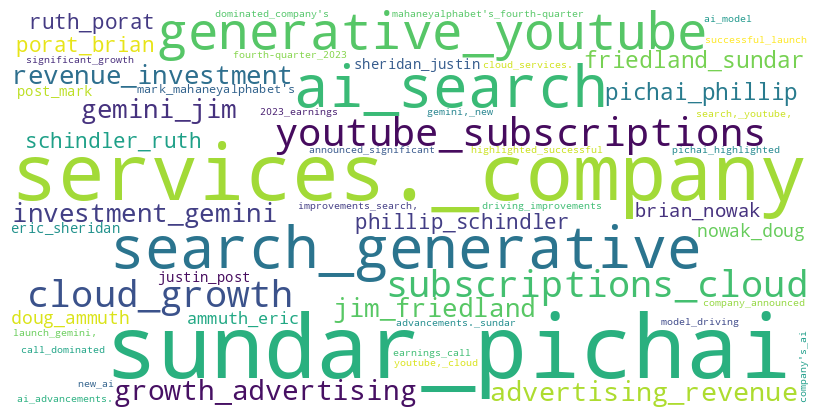

In [ ]:
create_wordcloud_with_ngrams(all_text, ngram_range=(2, 3))  # bigrams, and trigrams

### Video files

In [ ]:
#@title Video Feature Extraction Helper Functions

video_analysis_prompt = f"""Analyze the given video.
Extract the following:
1) Provide the overall sentiment as positive, negative, or neutral.
2) Extract the top 5 phrases that most strongly contribute to the overall sentiment.
3) Extract the top 10 most relevant keywords.
4) Summarize the video in 3-5 concise sentences. Focus on the main points, key findings, and overall takeaways.

Expected Output Format:
      {{
  "overall_sentiment": "positive/negative/neutral",
  "contributing_phrases": [
    "phrase 1",
    "phrase 2",
    "phrase 3",
    "phrase 4",
    "phrase 5"
  ],
  "keywords": [
    "keyword 1",
    "keyword 2",
    ...,
    "keyword 10"
  ],
  "summary": "summary of the audio"
}}
"""

def analyze_video_blob(blob: storage.Blob, video_analysis_prompt, video_data_type,
                       do_gemini_analysis: bool = True) -> Dict[str, any]:
    """Extracts metadata from a video blob, optionally using Gemini for analysis.

    Args:
        blob: The video blob to analyze.
        video_analysis_prompt: The prompt to use for Gemini video analysis.
        do_gemini_analysis: Whether to perform Gemini analysis (default: True).

    Returns:
        A dictionary containing metadata about the video.
    """
    video_bytes = io.BytesIO()

    with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as temp_file:
        blob.download_to_filename(temp_file.name)
        video = VideoFileClip(temp_file.name)
        size_mb = round(blob.size / (1024 * 1024), 2)

        metadata = {
            "blob_name": blob.name.split("/")[-1],
            "blob_path": get_blob_uri(blob.bucket.name, blob.name),
            "duration_in_min": round(video.duration / 60, 2),
            "size_in_mb": size_mb,
            "resolution": f"{video.size[0]}x{video.size[1]}",
            "fps": round(video.fps, 2),
            "data_type": video_data_type
        }

        if do_gemini_analysis:
            video_analysis_data = get_gemini_response_json(
                file_path=get_blob_uri(blob.bucket.name, blob.name),
                mime_type="video/mp4",
                analysis_prompt=video_analysis_prompt
            )
            metadata.update({
                "overall_sentiment": video_analysis_data["overall_sentiment"],
                "contributing_phrases": video_analysis_data["contributing_phrases"],
                "keywords": video_analysis_data["keywords"],
                "summary": video_analysis_data["summary"],
            })

        temp_file.close()  # Close the temporary file
        os.remove(temp_file.name)

    return metadata

def analyze_video_in_gcs(
    bucket: storage.Bucket, gcs_data_path: str, video_analysis_prompt,
    valid_extensions: List[str] = (".mp4", ".mov"),
    do_gemini_analysis: bool = True,

) -> pd.DataFrame:
    """Analyzes video files within a GCS bucket based on a prefix.

    Args:
        bucket: The GCS bucket to analyze.
        prefix: The prefix to filter blobs within the bucket.
        valid_extensions: A list of valid video file extensions (default: [".mp4", ".mov"]).

    Returns:
        A pandas DataFrame containing metadata about the analyzed videos.
    """
    video_metadata = []

    for blob in bucket.list_blobs(prefix=gcs_data_path):
        if blob.name.endswith(valid_extensions):
            data_type = blob.name.split("/")[-2]
            video_metadata.append(analyze_video_blob(blob, video_analysis_prompt,
                                                     data_type,
                                                     do_gemini_analysis))

    return pd.DataFrame(video_metadata)

In [ ]:
%%time

video_analysis_df = analyze_video_in_gcs(bucket,
                                   prototype_data,
                                   video_analysis_prompt
                                   )

CPU times: user 1.02 s, sys: 437 ms, total: 1.46 s
Wall time: 1min 16s


In [ ]:
video_analysis_df

,blob_name,blob_path,duration_in_min,size_in_mb,resolution,fps,data_type,overall_sentiment,contributing_phrases,keywords,summary
0,google_gemini_intro_video.mp4,gs://mlops-for-genai/multimodal-finanace-qa/da...,4.58,14.04,1280x720,29.97,prototype,positive,[most beneficial and consequential technology ...,"[google, gemini, ai, model, technology, inform...",The video highlights Google's latest AI breakt...
1,google_responsible_ai.mp4,gs://mlops-for-genai/multimodal-finanace-qa/da...,10.08,61.47,1280x720,29.97,prototype,positive,"[incredible progress, immense potential, bold ...","[AI, technology, responsible, bold, innovation...","James Manyika, Google's VP of Technology and S..."
2,google_search_next_phase_with_ai.mp4,gs://mlops-for-genai/multimodal-finanace-qa/da...,1.54,5.10,1280x720,29.97,prototype,positive,"[AI has been behind the evolution of Search, S...","[search, google, ai, evolution, answer, questi...",The video highlights the evolution of Google S...


In [ ]:
index = 1
print("Total time of video (in minute): ", video_analysis_df['duration_in_min'][index])
print("Size of video (in MB):", video_analysis_df['size_in_mb'][index])
print("Resolution of video: ", video_analysis_df['resolution'][index])
print("FPS of the video: ", video_analysis_df['fps'][index])
print("Data type: ", video_analysis_df['data_type'][index])

Total time of video (in minute):  10.08
Size of video (in MB): 61.47
Resolution of video:  1280x720
FPS of the video:  29.97
Data type:  prototype


In [ ]:
print("Overall sentiment of video:", video_analysis_df['overall_sentiment'][index])
print("\nContributing phrases of audio:")
video_analysis_df['contributing_phrases'][index]
print("\nKeywords of video:")
video_analysis_df['keywords'][index]
print("\nSummary of video:")
video_analysis_df['summary'][index]

Overall sentiment of video: positive

Contributing phrases of audio:


['incredible progress',
 'immense potential',
 'bold and responsible AI',
 'bold breakthroughs',
 'amazing and groundbreaking innovations']


Keywords of video:


['AI',
 'technology',
 'responsible',
 'bold',
 'innovation',
 'misinformation',
 'deepfakes',
 'universal translator',
 'perspective',
 'adversarial testing']


Summary of video:


"James Manyika, Google's VP of Technology and Society, discusses the importance of a bold and responsible approach to AI. He highlights groundbreaking innovations such as AlphaFold, which has accelerated scientific research by predicting the 3D shapes of millions of proteins. He also discusses the challenge of misinformation and the need for tools to evaluate online information, such as the 'About this image' feature in Google Search. Manyika stresses the importance of a collective effort involving researchers, social scientists, industry experts, governments, and individuals to build a vibrant content ecosystem that leverages AI responsibly."

In [ ]:
list1 = video_analysis_df['keywords'][index]
list2 = video_analysis_df['contributing_phrases'][index]
long_text  =  video_analysis_df['summary'][index]
all_text = ' '.join(list1 + list2) + long_text

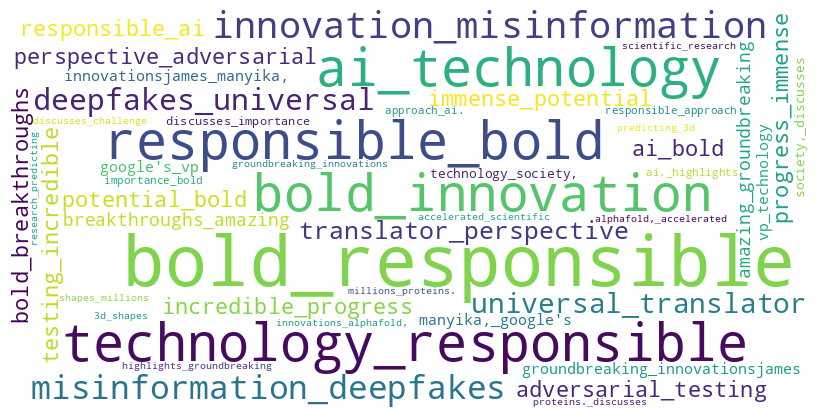

In [ ]:
create_wordcloud_with_ngrams(all_text, ngram_range=(2, 3))

### PDF files

In [ ]:
for blob in bucket.list_blobs():
  if blob.name.startswith(prototype_data) and blob.name.endswith(".pdf"):
    print(blob.name)


multimodal-finanace-qa/data/unstructured/prototype/goog-10-q-q2-2023-4-1-15.pdf
multimodal-finanace-qa/data/unstructured/prototype/google_cloud_tpu_blog_training.pdf


In [ ]:
#@title Document Feature Extraction Helper Functions

def analyze_pdfs_in_gcs(bucket_name, gcs_data_path, do_gemini_analysis=True, save_text=False):
    """
    Analyzes PDFs in a Google Cloud Storage bucket, optionally using Gemini for extraction.

    Args:
        bucket_name (str): Name of the GCS bucket.
        gcs_data_path (str): Path prefix to filter PDFs within the bucket.
        do_gemini_analysis (bool, optional): Whether to perform Gemini analysis (default: True).

    Returns:
        pandas.DataFrame: A DataFrame containing the analysis results for each PDF.
    """
    final_metadata = []

    for blob in bucket.list_blobs(prefix=gcs_data_path):  # Using prefix for filtering
        if blob.name.endswith(".pdf"):
            pdf_bytes = blob.download_as_bytes()
            pdf_file = BytesIO(pdf_bytes)
            pdf_reader = PyPDF2.PdfReader(pdf_file)

            number_pages = len(pdf_reader.pages)
            word_counts = []
            text_content = ""

            for page in pdf_reader.pages:
                page_text = page.extract_text()
                text_content += page_text
                word_counts.append(len(word_tokenize(page_text)))

            number_of_word_per_page = sum(word_counts) / number_pages if number_pages > 0 else 0  # Avoid division by zero

            metadata = {
                'blob_name': blob.name,
                'number_pages': number_pages,
                'number_of_word_per_page': number_of_word_per_page,
                'data_type': blob.name.split("/")[-2],
                'text': text_content if save_text else None
            }

            if do_gemini_analysis:
                document_analysis_data = get_gemini_response_json(
                    file_path=get_blob_uri(bucket.name, blob.name),
                    mime_type="application/pdf",
                    analysis_prompt=video_analysis_prompt
                )

                metadata.update({  # Update existing dictionary with new values
                    'contributing_phrases': document_analysis_data["contributing_phrases"],
                    'keywords': document_analysis_data["keywords"],
                    'summary': document_analysis_data["summary"]
                })

            final_metadata.append(metadata)  # Only append after Gemini analysis if needed

    return pd.DataFrame(final_metadata)

In [ ]:
%%time
document_analysis_df = analyze_pdfs_in_gcs(bucket, prototype_data)

CPU times: user 1.38 s, sys: 27.8 ms, total: 1.41 s
Wall time: 11.1 s


In [ ]:
document_analysis_df

,blob_name,number_pages,number_of_word_per_page,data_type,text,contributing_phrases,keywords,summary
0,multimodal-finanace-qa/data/unstructured/proto...,15,398.533333,prototype,None,"[we're gonna use that, i'm not sure i'm gonna ...","[time, pressure, gonna, able, make, feel, bett...",The video expresses a sense of uncertainty and...
1,multimodal-finanace-qa/data/unstructured/proto...,18,149.000000,prototype,None,[Google Cloud demonstrates the world's largest...,"[google cloud, tpu, training, llm, multislice,...",This article discusses Google Cloud's advancem...


In [ ]:
index = 1
print("Total pages in the document: ", document_analysis_df['number_pages'][index])
print("Avergae word per page:", document_analysis_df['number_of_word_per_page'][index])

Total pages in the document:  18
Avergae word per page: 149.0


In [ ]:
print("\nContributing phrases of document:")
document_analysis_df['contributing_phrases'][index]
print("\nKeywords of Document:")
document_analysis_df['keywords'][index]
print("\nSummary of video:")
document_analysis_df['summary'][index]


Contributing phrases of document:


["Google Cloud demonstrates the world's largest distributed training job for large language models across 50000+ TPU v5e chips",
 "Google Cloud TPU ran the world's largest distributed training job for LLMs across 50,000+ TPU v5e chips",
 'We achieved excellent scaling across 50,944 TPU v5e chips, but we believe we can improve this even further',
 'We demonstrated the benefits of Cloud TPU Multislice Training with what we believe is the largest (as of November 2023) publicly disclosed LLM distributed training job in the world',
 'As generative Al continues to trend towards bigger and bigger LLMs, we will continue to push the boundaries of innovation needed to further scale and improve our software stack.']


Keywords of Document:


['google cloud',
 'tpu',
 'training',
 'llm',
 'multislice',
 'distributed',
 'performance',
 'scaling',
 'job',
 'chips']


Summary of video:


"This article discusses Google Cloud's advancements in distributed training for large language models (LLMs) using TPUs. They highlight the successful implementation of Cloud TPU Multislice Training, which allows for efficient and scalable training across tens of thousands of TPU chips. This technology has enabled Google to achieve the world's largest publicly disclosed LLM training job, with a cluster of 50,944 Cloud TPU v5e chips. The article further delves into the technical details of the orchestration, compilation, and optimization processes involved in this massive training effort, demonstrating the impressive scaling and performance achieved. The article concludes by emphasizing the continued progress and advancements Google is making in this field, including plans to further enhance the software stack and explore new optimization techniques for even larger and more complex LLMs."

In [ ]:
list1 = document_analysis_df['contributing_phrases'][index]
list2 = document_analysis_df['keywords'][index]
long_text  =  document_analysis_df['summary'][index]
all_text = ' '.join(list1 + list2) + long_text

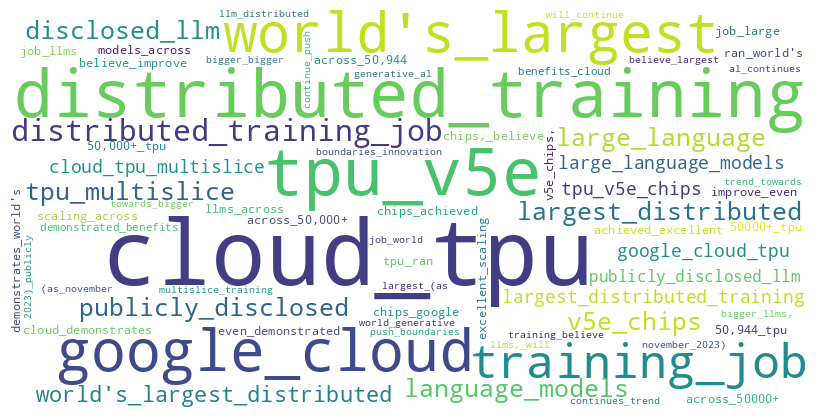

In [ ]:
create_wordcloud_with_ngrams(all_text, ngram_range=(2, 3))

## Exploring Production Data

### PDF Files

In [ ]:
%%time
document_analysis_df = analyze_pdfs_in_gcs(bucket,
                                           production_data,
                                           do_gemini_analysis=False,
                                           save_text=True
                                           )

CPU times: user 2min 18s, sys: 666 ms, total: 2min 18s
Wall time: 2min 25s


In [ ]:
print("Total documents: ", document_analysis_df.shape[0])

Total documents:  31


<Axes: xlabel='data_type', ylabel='count'>

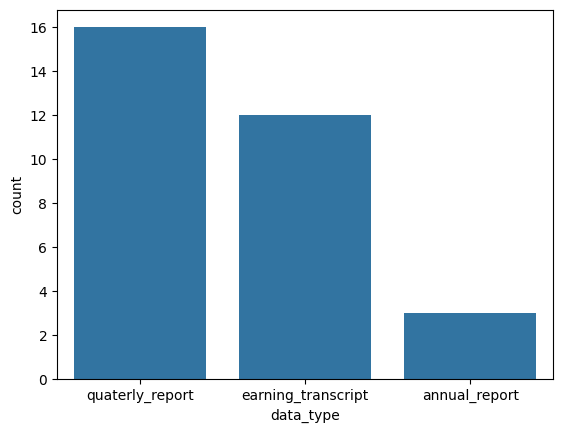

In [ ]:
sns.barplot(document_analysis_df['data_type'].value_counts())

<Axes: xlabel='number_pages', ylabel='number_of_word_per_page'>

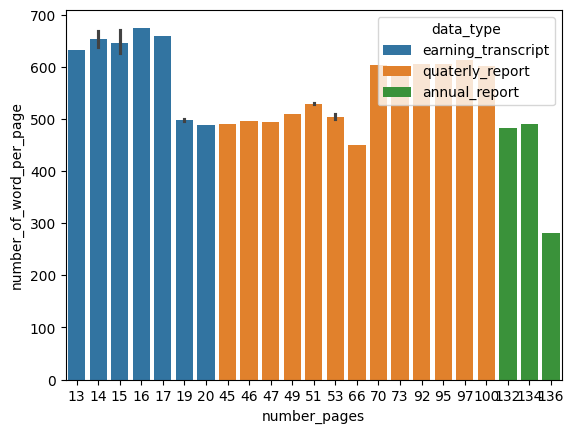

In [ ]:
import seaborn as sns
data_subset = document_analysis_df[['data_type','number_pages','number_of_word_per_page']]
sns.barplot(data_subset, x="number_pages", y="number_of_word_per_page", hue="data_type")

<Axes: xlabel='number_pages', ylabel='number_of_word_per_page'>

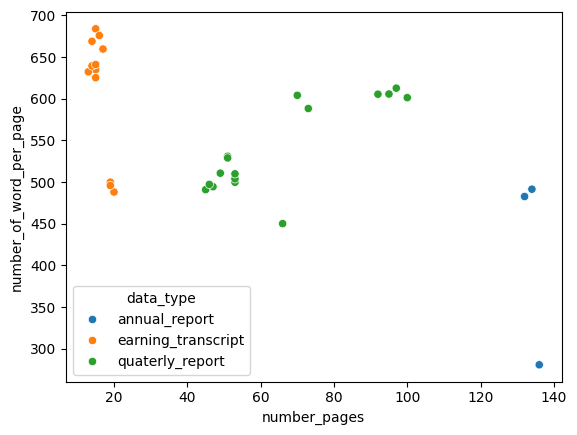

In [ ]:
sns.scatterplot(data=document_analysis_df, x="number_pages",
                y="number_of_word_per_page", hue="data_type")

In [ ]:
document_analysis_df.head()

,blob_name,number_pages,number_of_word_per_page,data_type,text
0,multimodal-finanace-qa/data/unstructured/produ...,134,491.410448,annual_report,Alphabet \n2020\nAlphabet 2020 Annual Report\...
1,multimodal-finanace-qa/data/unstructured/produ...,17,659.588235,earning_transcript,This transcript is provided for the convenienc...
2,multimodal-finanace-qa/data/unstructured/produ...,15,634.866667,earning_transcript,This transcript is provided for the convenienc...
3,multimodal-finanace-qa/data/unstructured/produ...,13,632.230769,earning_transcript,This transcript is provided for the convenienc...
4,multimodal-finanace-qa/data/unstructured/produ...,14,668.857143,earning_transcript,This transcript is provided for the convenienc...


In [ ]:
index = 25
print("Total pages in the document: ", document_analysis_df['number_pages'][index])
print("Avergae word per page:", document_analysis_df['number_of_word_per_page'][index])
print("Document Type: ", document_analysis_df['data_type'][index])
print("Document Name: ", document_analysis_df['blob_name'][index].split("/")[-1])

Total pages in the document:  53
Avergae word per page: 499.7169811320755
Document Type:  quaterly_report
Document Name:  20221025-alphabet-10q.pdf


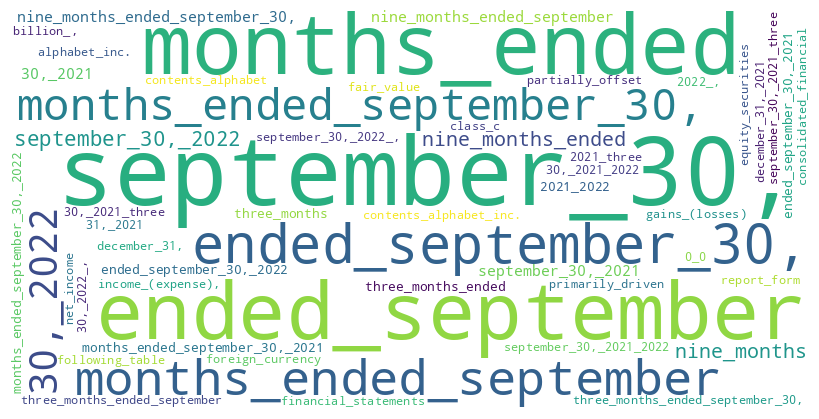

In [ ]:
all_text = document_analysis_df['text'][index]
create_wordcloud_with_ngrams(all_text, ngram_range=(2, 5))

### Audio Files

In [ ]:
%%time

audio_analysis_df = analyze_audio_in_gcs(bucket,production_data,
                                          audio_sentiment_analysis_prompt,
                                          # do_gemini_analysis=False # for faster processing ~3 sec
                                         )

CPU times: user 23.3 s, sys: 23.7 s, total: 47 s
Wall time: 5min 58s


In [ ]:
audio_analysis_df.head()

,duration_in_min,size_in_mb,sampling_rate_in_hz,channels,blob_name,blob_path,data_type,overall_sentiment,contributing_phrases,keywords,speakers,summary
0,56.822857,52.023012,44100,2,Alphabet 2023 Q2 Earnings Call (128 kbps).mp3,gs://mlops-for-genai/multimodal-finanace-qa/da...,earning_call,positive,"[We are holding our call from London today., I...","[AI, Google, Cloud, YouTube, Search, Growth, R...","[Gemini, Jim Friedland, Sundar Pichai, Philip ...",Alphabet's second quarter 2023 earnings confer...
1,51.733333,47.363415,44100,2,Alphabet 2023 Q3 Earnings Call (128 kbps).mp3,gs://mlops-for-genai/multimodal-finanace-qa/da...,earning_call,positive,[very pleased with our business results this q...,"[AI, search, YouTube, cloud, growth, revenue, ...","[Jim Freidland, Sundar Pichai, Philip Schindle...",Alphabet's third quarter 2023 earnings call wa...
2,56.799782,52.001887,44100,2,Alphabet 2024 Q2 Earnings Call (128 kbps).mp3,gs://mlops-for-genai/multimodal-finanace-qa/da...,earning_call,positive,[I'm really pleased with our results this quar...,"[AI, search, cloud, Gemini, YouTube, revenue, ...","[Operator, Jim Friedland, Sundar Pichai, Phili...",Alphabet's second-quarter 2024 earnings call h...
3,57.333569,52.540179,44100,2,Alphabet_2023_Q1_Earnings_Call.mp3,gs://mlops-for-genai/multimodal-finanace-qa/da...,earning_call,positive,"[pleased with the business performance, huge o...","[AI, search, cloud, YouTube, revenue, growth, ...","[Operator, Jim Friedland, Sundar Pichai, Phili...",Alphabet's first-quarter earnings call was pos...
4,56.860667,78.087566,48000,2,Alphabet_2023_Q4_Earnings_Call.mp3,gs://mlops-for-genai/multimodal-finanace-qa/da...,earning_call,positive,"[strong momentum and product innovation, we ar...","[AI, search, YouTube, cloud, revenue, growth, ...","[Gemini, Jim Friedland, Sundar Pichai, Philip ...",Alphabet's fourth-quarter 2023 earnings call h...


<Axes: xlabel='duration_in_min', ylabel='size_in_mb'>

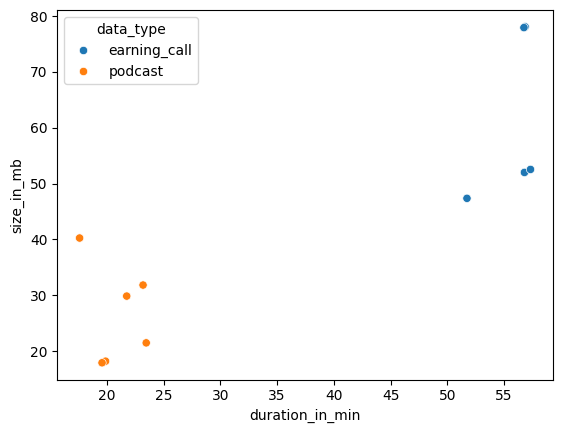

In [ ]:
sns.scatterplot(data=audio_analysis_df, x="duration_in_min",
                y="size_in_mb", hue="data_type")

In [ ]:
index = 5
print("Name of the audio: ", audio_analysis_df['blob_name'][index].split("/")[-1])
print("Total time of audio (in minute): ", audio_analysis_df['duration_in_min'][index])
print("Size of audio (in MB):", audio_analysis_df['size_in_mb'][index])
print("Sampling rate of audio (in Hertz): ", audio_analysis_df['sampling_rate_in_hz'][index])
print("Channels of audio: ", audio_analysis_df['channels'][index])
print("Audio Type: ", audio_analysis_df['data_type'][index])

Name of the audio:  Alphabet_2024_Q1_Earnings_Call.mp3
Total time of audio (in minute):  56.754
Size of audio (in MB): 77.94089889526367
Sampling rate of audio (in Hertz):  48000
Channels of audio:  2
Audio Type:  earning_call


In [ ]:
print("Overall sentiment of audio:", audio_analysis_df['overall_sentiment'][index])
print("\nContributing phrases of audio:")
audio_analysis_df['contributing_phrases'][index]
print("\nKeywords of audio:")
audio_analysis_df['keywords'][index]
print("\nSpeakers of audio:")
audio_analysis_df['speakers'][index]
print("\nSummary of audio:")
audio_analysis_df['summary'][index]

Overall sentiment of audio: positive

Contributing phrases of audio:


['It was a great quarter',
 'We are very pleased with our financial results for the first quarter',
 'We are very pleased to be adding a quarterly dividend of 20 cents per share to our capital return program',
 'We are very pleased with the momentum of our ads businesses',
 'We are seeing a similar shift happening now with generative AI.']


Keywords of audio:


['AI',
 'search',
 'cloud',
 'revenue',
 'growth',
 'YouTube',
 'generative AI',
 'opportunities',
 'investment',
 'capital']


Speakers of audio:


['Gemini', 'Jim Friedland', 'Sundar Pichai', 'Philip Schindler', 'Ruth Porat']


Summary of audio:


"Alphabet's Q1 2024 earnings call was positive, driven by strong performance in search, YouTube, and cloud.  Sundar Pichai highlighted the company's leadership in AI, citing research, infrastructure, and product advancements, particularly with the Gemini model.  Philip Schindler emphasized the impact of AI on advertising, noting strong growth in YouTube ads and the successful integration of Gemini into performance max.  Ruth Porat detailed financial results, highlighting the 15% increase in consolidated revenue, strong operating income, and the company's continued investment in AI and infrastructure.  The call concluded with a positive outlook for the future, with a focus on continued investment in AI and a commitment to maximizing returns."

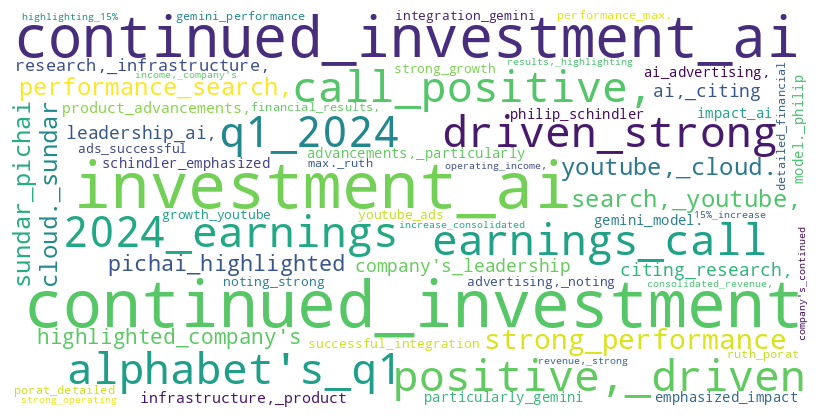

In [ ]:
all_text = audio_analysis_df['summary'][index]
create_wordcloud_with_ngrams(all_text, ngram_range=(2, 3))

### Video Files

In [ ]:
%%time

video_analysis_df = analyze_video_in_gcs(bucket,
                                   production_data,
                                   video_analysis_prompt,
                                   # do_gemini_analysis=False # for faster processing ~ 10 sec
                                   )

CPU times: user 3.25 s, sys: 772 ms, total: 4.02 s
Wall time: 6min 1s


In [ ]:
print("Total Video Files: ", video_analysis_df.shape[0])

Total Video Files:  18


In [ ]:
video_analysis_df.head()

,blob_name,blob_path,duration_in_min,size_in_mb,resolution,fps,data_type,overall_sentiment,contributing_phrases,keywords,summary
0,Can AI understand new emojis Testing Gemini.mp4,gs://mlops-for-genai/multimodal-finanace-qa/da...,1.16,1.53,1280x720,24.00,gemini,positive,"[Can Gemini understand unusual emojis?, It's a...","[gemini, emojis, understand, unusual, images, ...",This video explores the capabilities of Gemini...
1,Can AI understand your outfit Testing Gemini.mp4,gs://mlops-for-genai/multimodal-finanace-qa/da...,0.74,1.98,1280x720,24.00,gemini,positive,"[pretty good, that's actually pretty good, tha...","[gemini, understand, outfit, visual, test, pre...",This video explores the capabilities of Gemini...
2,Converting images into code with AI Testing G...,gs://mlops-for-genai/multimodal-finanace-qa/da...,0.97,1.91,1280x720,24.00,gemini,positive,"[pretty good, pretty cool, that's pretty good,...","[gemini, images, code, turn, interactive, java...",The video demonstrates the capabilities of Gem...
3,Finding connections with AI Testing Gemini.mp4,gs://mlops-for-genai/multimodal-finanace-qa/da...,0.99,1.95,1280x720,24.00,gemini,positive,"[pretty good, that worked, I like this, wow, t...","[Gemini, images, similarities, connection, und...",The video showcases the capabilities of Google...
4,Googles newest AI in 90 seconds Gemini.mp4,gs://mlops-for-genai/multimodal-finanace-qa/da...,1.50,3.59,1280x720,29.97,gemini,positive,"[It's been a monumental engineering task, Gemi...","[gemini, model, ai, google, deepmind, capable,...","The video introduces Gemini, Google's new and ..."


<Axes: xlabel='duration_in_min', ylabel='size_in_mb'>

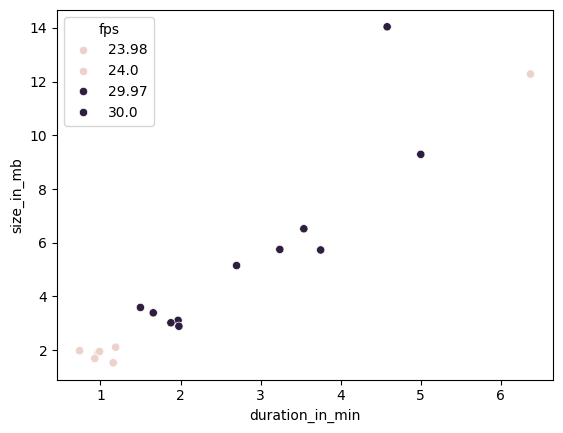

In [ ]:
sns.scatterplot(data=video_analysis_df, x="duration_in_min",
                y="size_in_mb", hue="fps")

In [ ]:
index = 14
print("Name of the video: ", video_analysis_df['blob_name'][index].split("/")[-1])
print("Total time of video (in minute): ", video_analysis_df['duration_in_min'][index])
print("Size of video (in MB):", video_analysis_df['size_in_mb'][index])
print("Resolution of video: ", video_analysis_df['resolution'][index])
print("FPS of the video: ", video_analysis_df['fps'][index])
print("Data type: ", video_analysis_df['data_type'][index])

Name of the video:  The capabilities of multimodal AI  Gemini Demo.mp4
Total time of video (in minute):  6.37
Size of video (in MB): 12.28
Resolution of video:  1280x720
FPS of the video:  23.98
Data type:  gemini


In [ ]:
print("Overall sentiment of video:", video_analysis_df['overall_sentiment'][index])
print("\nContributing phrases of audio:")
video_analysis_df['contributing_phrases'][index]
print("\nKeywords of video:")
video_analysis_df['keywords'][index]
print("\nSummary of video:")
video_analysis_df['summary'][index]

Overall sentiment of video: positive

Contributing phrases of audio:


["We've been testing the capabilities of Gemini, our new multimodal AI model.",
 'This video highlights some of our favorite interactions with Gemini.',
 'It looks like blue ducks are more common than I thought!',
 'You did a good job of capturing the beauty of Gemini.',
 "I'll keep those in mind."]


Keywords of video:


['Gemini',
 'multimodal',
 'AI',
 'model',
 'testing',
 'capabilities',
 'video',
 'highlights',
 'interactions',
 'favorite']


Summary of video:


"This video showcases Gemini, Google's new multimodal AI model. It demonstrates Gemini's ability to understand and respond to visual prompts.  Gemini successfully identifies objects, reasons about their properties, and even generates creative content. The video highlights a variety of scenarios where Gemini excels, including interpreting drawings, solving puzzles, and making predictions. Overall, the video presents a positive outlook on the potential of Gemini as a powerful and versatile AI tool."

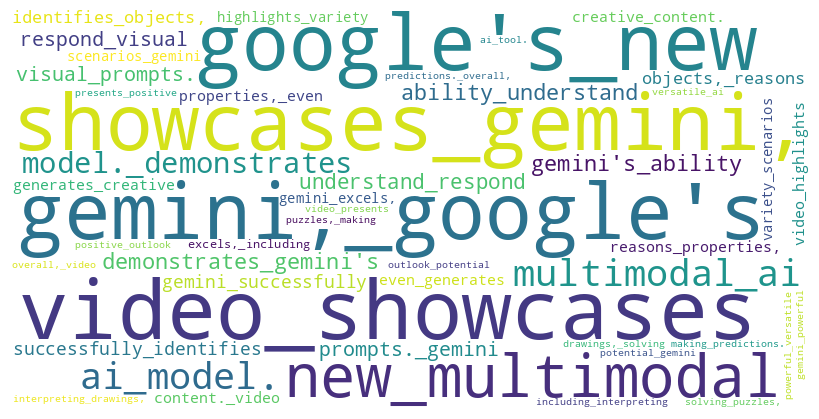

In [ ]:
all_text = video_analysis_df['summary'][index]
create_wordcloud_with_ngrams(all_text, ngram_range=(2, 5))

## Misc Code [Remove]

In [ ]:
import io
import librosa
import soundfile as sf

# ... (Your code to connect to GCS bucket) ...

for blob in bucket.list_blobs(prefix=production_data):
    if blob.name.endswith(".mp3"):
        print(blob.name)

        # Download blob contents into memory
        audio_data = blob.download_as_bytes()

        # Create BytesIO object from audio data
        audio_bytes = io.BytesIO(audio_data)

        # Read audio using librosa and soundfile
        # Use FFmpeg backend
        try:
            y, sr = librosa.load(audio_bytes, sr=None)
        except sf.LibsndfileError:
            # Fallback to sf.read
            try:
                y, sr = sf.read(audio_bytes)
            except RuntimeError as e:
                print(f"Error reading {blob.name}: {e}. Skipping...")
                continue

        # Calculate duration and file size
        duration_seconds = librosa.get_duration(y=y, sr=sr)
        file_size_mb = blob.size / (1024 * 1024)

        print({
            "duration_in_min": duration_seconds / 60,
            "size_in_mb": file_size_mb,
            "sampling_rate_in_hz": sr,
            "channels": y.shape[0] if len(y.shape) > 1 else 1,
        })

In [ ]:
for blob in bucket.list_blobs(prefix=production_data):  # Using prefix for efficiency
    if blob.name.endswith(".mp3"):
        print(blob.name)
        audio_bytes = io.BytesIO()
        blob.download_to_file(audio_bytes)
        audio_bytes.seek(0)
        try:
          try:
            audio = AudioSegment.from_file(audio_bytes, format="mp3")
          except:
            audio = AudioSegment.from_file(audio_bytes, format="mp4")
        except Exception as e:
            print("Skipping")
            pass


        print( {
            "duration_in_min": audio.duration_seconds / 60,
            "size_in_mb": len(audio_bytes.getvalue()) / (1024 * 1024),
            "sampling_rate_in_hz": audio.frame_rate,
            "channels": audio.channels,
        })

In [ ]:
for blob in bucket.list_blobs():
  if blob.name.startswith(production_data) and blob.name.endswith(".mp3"):
    # print(blob.name)
    # print(blob.name.split("/")[-2])
    print(get_blob_uri(bucket.name, blob.name))

## Conclusion

[add conclusions & Next Steps]